<a href="https://colab.research.google.com/github/Ashwini010595/Computer_Vision/blob/main/Assignment_2_CS5620.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Assignment 2 - Computer Vision - CS5620.**

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you sould not change anything else code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Part-1

In [13]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# %matplotlib inline uncomment this line if you're running this notebook on your local PC

In [14]:
# DO NOT CHANGE THIS CODE
np.random.seed(10)

### Question 1 : Line detection from a given image.


Find the starting and ending point co-ordinates of detected lines of a given image using hough transform. 

Following criterion need to be satisfied to qualify as a line:

(a) Minimum line length = 60;
(b) Maximum allowed gap between line segments = 250;
(c) Accumulator threshold parameter = 15  (only those lines are returned that get enough votes);
(d) Distance resolution of the accumulator in pixels = 1;
(e) Angle resolution of the accumulator in radians = pi/180


Which of the following pairs of (start, end) co-ordinates of detected lines are true:

1. line-1: (1,81), (27,9) ; line-2 : (92,0), (95,64)
2. line-1: (2,79), (26,11) ; line-2 : (92,1), (94,67)
3. line-1: (2,80), (26,10) ; line-2: (91,2), (96,65)
4.  None of the above

Answer: None of the above

# Solution to Question 1

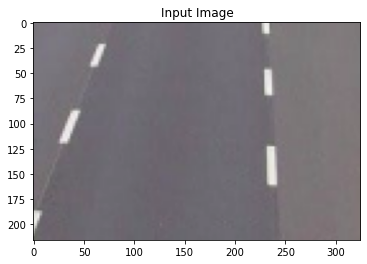

start and end coordinates:  (26, 118) (64, 22)
start and end coordinates:  (229, 47) (231, 159)
start and end coordinates:  (1, 204) (71, 22)
start and end coordinates:  (234, 0) (240, 161)
start and end coordinates:  (0, 211) (72, 22)
start and end coordinates:  (231, 153) (233, 11)
start and end coordinates:  (241, 161) (241, 132)
start and end coordinates:  (26, 115) (62, 25)
start and end coordinates:  (29, 112) (65, 22)


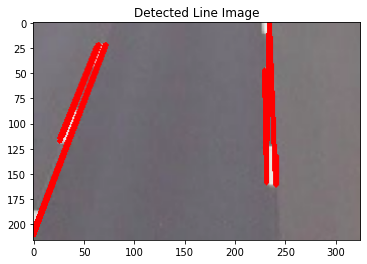

In [17]:
#Read image 
img = cv2.imread('line.png', cv2.IMREAD_COLOR)

# Visualize the input image
plt.imshow(img)
plt.title('Input Image')
plt.show()


#convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Find the edges in the image using canny detector

edges = cv2.Canny(gray, 50, 200)

####YOUR CODE STARTS HERE #####
#Detect points that forms a line (you can use Hough lines)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 15,60, maxLineGap=250)

#Draw lines on the image
for line in lines:
    x1,y1,x2,y2 = line[0]
    print ("start and end coordinates: ", (x1,y1),(x2,y2) )
    cv2.line(img, (x1,y1), (x2,y2), (255,0,0), 3)

####YOUR CODE ENDS HERE #####
plt.imshow(img)
plt.title('Detected Line Image')
plt.show()

##Question 2: Point matching using RANSAC

Given two sets of points related by affine transformation(with an outlier rate), use the RANSAC method to estimate the Affine transformation parameters between them and the number of inliers(Matching points).

Which of the following is the estimated number of inliers for an outlier rate of 0.9:

1. 89
2. 101
3. 117
4. 132

Answer: 101

# Solution to Question 2

In [11]:
import numpy as np
np.random.seed(0)


# Affine Transform
# |x'|  = |a, b| * |x|  +  |tx|
# |y'|    |c, d|   |y|     |ty|
# pts_t =    A   * pts_s  + t

# -------------------------------------------------------------
# Test Class Affine

class Affine_Transform():

    def create_test_case(self, outlier_rate=0):
        ''' CREATE_TEST_CASE

            Randomly generate a test case of affine transformation.

            Input arguments:

            - outlier_rate : the percentage of outliers in test case,
            default is 0

            Outputs:

            - pts_s : Source points that will be transformed
            - pts_t : warped points
            - A, t : parameters of affine transformation, A is a 2x2
            matrix, t is a 2x1 vector, both of them are created randomly

        '''

        # Randomly generate affine transformation
        # A is a 2x2 matrix, the range of each value is from -2 to 2
        A = 4 * np.random.rand(2, 2) - 2

        # % t is a 2x1 VECTOR, the range of each value is from -10 to 10
        t = 20 * np.random.rand(2, 1) - 10

        # Set the number of points in test case
        num = 1000

        # Compute the number of outliers and inliers respectively
        outliers = int(np.round(num * outlier_rate))
        inliers = int(num - outliers)

        # Gernerate source points whose scope from (0,0) to (100, 100)
        pts_s = 100 * np.random.rand(2, num)
        # Initialize warped points matrix
        pts_t = np.zeros((2, num))

        # Compute inliers in warped points matrix by applying A and t
        pts_t[:, :inliers] = np.dot(A, pts_s[:, :inliers]) + t

        # Generate outliers in warped points matrix
        pts_t[:, inliers:] = 100 * np.random.rand(2, outliers)

        # Reset the order of warped points matrix,
        # outliers and inliers will scatter randomly in test case
        rnd_idx = np.random.permutation(num)
        pts_s = pts_s[:, rnd_idx]
        pts_t = pts_t[:, rnd_idx]

        return A, t, pts_s, pts_t

    def estimate_affine(self, pts_s, pts_t):
        ''' ESTIMATE_AFFINE

            Estimate affine transformation by the given points
            correspondences.

            Input arguments:
            - pts_t : points in target image
            - pts_s : points in source image

            Outputs:

            - A, t : the affine transformation, A is a 2x2 matrix
            that indicates the rotation and scaling transformation,
            t is a 2x1 vector determines the translation

            Method:

            To estimate an affine transformation between two images,
            at least 3 corresponding points are needed.
            In this case, 6-parameter affine transformation are taken into
            consideration, which is shown as follows:

            | x' | = | a b | * | x | + | tx |
            | y' |   | c d |   | y |   | ty |

            For 3 corresponding points, 6 equations can be formed as below:

            | x1 y1 0  0  1 0 |       | a  |       | x1' |
            | 0  0  x1 y1 0 1 |       | b  |       | y1' |
            | x2 y2 0  0  1 0 |   *   | c  |   =   | x2' |
            | 0  0  x2 y2 0 1 |       | d  |       | y2' |
            | x3 y3 0  0  1 0 |       | tx |       | x3' |
            | 0  0  x3 y3 0 1 |       | ty |       | y3' |

            |------> M <------|   |-> theta <-|   |-> b <-|

            Solve the equation to compute theta by:  theta = M \ b
            Thus, affine transformation can be obtained as:

            A = | a b |     t = | tx |
                | c d |         | ty |

        '''

        # Get the number of corresponding points
        pts_num = pts_s.shape[1]

        # Initialize the matrix M,
        # M has 6 columns, since the affine transformation
        # has 6 parameters in this case
        M = np.zeros((2 * pts_num, 6))

        for i in range(pts_num):
            # Form the matrix m
            temp = [[pts_s[0, i], pts_s[1, i], 0, 0, 1, 0],
                    [0, 0, pts_s[0, i], pts_s[1, i], 0, 1]]
            M[2 * i: 2 * i + 2, :] = np.array(temp)

        # Form the matrix b,
        # b contains all known target points
        b = pts_t.T.reshape((2 * pts_num, 1))

        try:
            # Solve the linear equation
            theta = np.linalg.lstsq(M, b)[0]

            # Form the affine transformation
            A = theta[:4].reshape((2, 2))
            t = theta[4:]
        except np.linalg.linalg.LinAlgError:
            # If M is singular matrix, return None
            # print("Singular matrix.")
            A = None
            t = None

        return A, t
# -------------------------------------------------------------

# Create instance
af = Affine_Transform()

# Generate a test case as validation with
# a rate of outliers
outlier_rate = 0.90
A_true, t_true, pts_s, pts_t = af.create_test_case(outlier_rate)

# At least 3 corresponding points to
# estimate affine transformation
K = 3
# Randomly select 3 pairs of points to do estimation
idx = np.random.randint(0, pts_s.shape[1], (K, 1))

A_test, t_test = af.estimate_affine(pts_s[:, idx], pts_t[:, idx])

# Display known parameters with estimations
# They should be same when outlier_rate equals to 0,
# otherwise, they are totally different in some cases
#print(A_true, '\n', t_true)
#print(A_test, '\n', t_test)

# -------------------------------------------------------------
# Test Class Ransac
# The number of iterations in RANSAC
ITER_NUM = 2000


class Ransac():

    def __init__(self, K=3, threshold=1):
        ''' __INIT__

            Initialize the instance.

            Input argements:

            - K : the number of corresponding points,
            default is 3
            - threshold : determing which points are inliers
            by comparing residual with it

        '''

        self.K = K
        self.threshold = threshold

    def residual_lengths(self, A, t, pts_s, pts_t):
        ''' RESIDUAL_LENGTHS

            Compute residual length (Euclidean distance) between
            estimation and real target points. Estimation are
            calculated by the given source point and affine
            transformation (A & t).

            Input arguments:

            - A, t : the estimated affine transformation calculated
            by least squares method
            - pts_s : key points from source image
            - pts_t : key points from target image

            Output:

            - residual : Euclidean distance between estimated points
            and real target points

        '''

        if not(A is None) and not(t is None):
            # Calculate estimated points:
            # pts_e = A * pts_s + t
            pts_e = np.dot(A, pts_s) + t

            # Calculate the residual length between estimated points
            # and target points
            diff_square = np.power(pts_e - pts_t, 2)
            residual = np.sqrt(np.sum(diff_square, axis=0))
        else:
            residual = None

        return residual

    def ransac_fit(self, pts_s, pts_t):
        ''' RANSAC_FIT

            Apply the method of RANSAC to obtain the estimation of
            affine transformation and inliers as well.

            Input arguments:

            - pts_s : key points from source image
            - pts_t : key points from target image

            Output:

            - A, t : estimated affine transformation
            - inliers : indices of inliers that will be applied to refine the
            affine transformation

        '''
        #### YOUR CODE START HERE
        # Create a Affine instance to do estimation
        a = Affine_Transform()
        

        # Initialize the number of inliers
        inliers_num = 0

        # Initialize the affine transformation A and t,
        # and a vector that stores indices of inliers
        A = None
        t = None
        inliers = np.array([])

        for i in range(ITER_NUM):
            # Randomly generate indices of points correspondences
            ind = np.random.randint(0, pts_s.shape[1], (self.K, 1))
            if len(np.unique(ind)) < self.K:
                continue
            
            # Estimate affine transformation by these points
            A_tmp, t_tmp = a.estimate_affine(pts_s[:, ind], pts_t[:, ind])
            

            # Calculate the residual by applying estimated transformation
            residual = self.residual_lengths(A_tmp, t_tmp, pts_s, pts_t)
            

            if not(residual is None):
                # Obtain the indices of inliers
                inliers_tmp = np.where(residual < self.threshold)
                
                # Obtain the number of inliers
                inliers_num_tmp = len(inliers_tmp[0])

                # Set affine transformation and indices of inliers
                # in one iteration which has the most of inliers
                if inliers_num_tmp > inliers_num:
                    # Update the number of inliers
                    inliers_num = inliers_num_tmp
                    # Set returned value
                    inliers = inliers_tmp
                    A = A_tmp
                    t = t_tmp
            else:
                pass
        ### YOUR CODE ENDS HERE
        return A, t, inliers
# -------------------------------------------------------------

# Create instance
rs = Ransac(K=3, threshold=1)

residual = rs.residual_lengths(A_test, t_test, pts_s, pts_t)
#print(residual)

# Run RANSAC to estimate affine transformation when
# too many outliers in points set
A_rsc, t_rsc, inliers = rs.ransac_fit(pts_s, pts_t)
#print(A_rsc, '\n', t_rsc)
# print the number of inliners or point matches
print ("Inliners",inliers[0].shape)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Inliners (101,)


### Question 3: Detect corners in a given image using Harris Corner Detection Algorithm

Find the number of detected corner points in a given image using Harris Corner Detection Algorithm. Note that, Following criterion MUST be satisfied while applying Harris Corner detection Algorithm:

(a)  The size of neighbourhood considered for corner detection = 2.
(b)  Aperture parameter of Sobel derivative used = 3.
(c)  Harris detector free parameter in the equation = 0.04.

which of the following are true?

1.   169
2.   222
3.   264
4.   309


# Solution to Question 3

Number of Detected Corners:  256


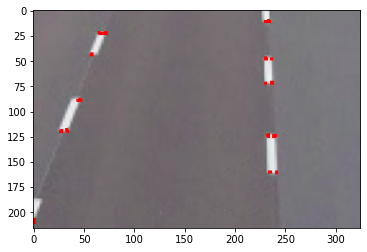

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

# Read in the image
image = cv2.imread('line.png')

# Make a copy of the image
image_copy = np.copy(image)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

###YOUR CODE STARTS HERE

## STEP 1:  Convert to grayscale 
gray = cv2.cvtColor(image_copy,cv2.COLOR_RGB2GRAY)
gray = np.float32(gray)

## STEP 2: Detect corners 
dilst = cv2.cornerHarris(gray,2,3,0.04)

## STEP 3: Dilate corner image to enhance corner points
dilst = cv2.dilate(dilst,None)

plt.imshow(dilst, cmap='gray')


## STEP 4:set threshold value as 0.1 * (maximum value of dilated corner image obtained from STEP3)
threshold = 0.1*dilst.max()

#STEP 5: Count numer of detected corner points and draw them on the image
# Create an image copy to draw corners on
corner_image = np.copy(image_copy)
count = len(corner_image[dilst>threshold])
corner_image[dilst>threshold]=[255,0,0]


# Iterate through all the corners and draw them on the image (if they pass the threshold)


print ("Number of Detected Corners: ", count)
plt.imshow(corner_image)

### YOUR CODE ENDS HERE